In [4]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
import requests
import re
import os
import zipfile
import collections
import urllib.request
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML
from collections import defaultdict
import time
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [6]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.4.1
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Reading the data

In [8]:
%%capture
# !unzip "./all_data/sep_1/data.zip" -d "./temp_data/sep_1/"

In [17]:
# Getting the folder names 
folder_names = glob.glob("./temp_data/sep_1/data/*")

In [19]:
# Getting the data names
data_names = []
for i in folder_names:
    data_names.append(glob.glob(i+"/*.csv"))

## Data Loading

In [20]:
# Datasets to skip 
skip = []

# Labels of the datasets
labels = []

# Data list 
data = []


# Getting the labels and data for each dataset
for i in range(len(data_names)):
    if i in skip:
        continue
    
    for j in range(len(data_names[i])):
        labels.append([data_names[i][j][data_names[i][j].find(".csv")-1]])
        
        # Cleaning data
        df = pd.read_csv(data_names[i][j],skiprows = 1)
        df.drop(columns=df.columns[-1], axis=1,  inplace=True)
        
        data.append(df)

In [24]:
# Changing the labels from int to string
labels = [int(i)-1 for i in np.reshape(labels,(-1,))]

## Adding Features

In [25]:
# Adding the centroid of all the fingers to the data

new_data = []

for idx_1 in range(len(data)):

    
    # Grouped columns for centroid
    grouped_columns_x = data[idx_1].columns[3::3] 
    grouped_columns_y = data[idx_1].columns[4::3]
    grouped_columns_z = data[idx_1].columns[5::3]
    
    # Getting the centroid of the finger points
    cent_x = np.mean(data[idx_1][grouped_columns_x],axis = 1)
    cent_y = np.mean(data[idx_1][grouped_columns_y],axis = 1)
    cent_z = np.mean(data[idx_1][grouped_columns_z],axis = 1)
    
    new_data.append(pd.concat([data[idx_1],cent_x,cent_y,cent_z],axis = 1))
    

## Data Cleaning

In [173]:
# Pulling only the centroid data 
cent_data = [i.iloc[:,-3:] for i in new_data]

Text(0, 0.5, 'Number of trajectories')

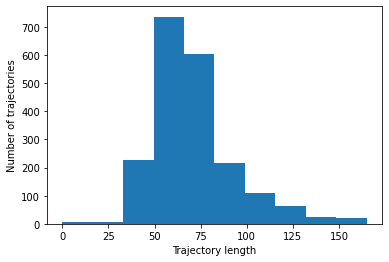

In [174]:
lengths = np.array([len(i) for i in cent_data])
plt.hist(lengths)
plt.xlabel("Trajectory length")
plt.ylabel("Number of trajectories")

In [175]:
# Removing trajectories with <=5 length
idx = np.where(lengths <= 5.)[0]
[labels.pop(j-i) for i,j in enumerate(idx)]
[cent_data.pop(j-i) for i,j in enumerate(idx)];

In [176]:
# Checking to see if it worked 
lengths = np.array([len(i) for i in cent_data])
np.where(lengths <= 5.)

(array([], dtype=int64),)

In [177]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(cent_data, labels, test_size=0.2)

## Data Augmentation

In [178]:
x_train_aug = []
for idx,i in enumerate(x_train):
    ch = np.random.choice([0,1],p = [0.3,0.7])

    flag = 0 

    if ch == 0: # Perform data augmentation

    trim = len(i)//2

    if trim >= 5: # Trim if the lengths are greater than 5

        aug = i.head(trim)

    else: # If lengths are not greater than 1, don't trim

        aug = i
    else:
    aug = i


    x_train_aug.append(aug)


In [180]:
# Printing out the lengths after and before augmentation
len(x_train_aug), len(x_train)

(1605, 1605)

## Data Formatting

In [181]:
# Getting the data in the required format for the model
# Creating labels for RNN's output 
y_train = [[dt]*200 for idx,dt in enumerate(y_train)]
y_test = [[dt]*200 for idx,dt in enumerate(y_test)]

In [182]:
# Sequence length is based on data analysis
x_train = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', dtype='float', maxlen=200))
y_train = tf.convert_to_tensor(y_train)

x_test = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', dtype='float', maxlen=200))
y_test = tf.convert_to_tensor(y_test)

In [183]:
# One hot encoding the data for training
y_train = tf.one_hot(y_train, 9, on_value = 1.0, off_value = 0.0)
y_test = tf.one_hot(y_test, 9, on_value = 1.0, off_value = 0.0)

## Model loading and testing

In [140]:
# Testing the saved model
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5')
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5')
# model_load = load_model('./models/rnn.h5')
model_load.evaluate(x_test,y_test)

13/13 [==============================] - 1s 8ms/step - loss: 0.4526 - accuracy: 0.8438


[0.45259910821914673, 0.8438432812690735]

In [9]:
!rm -rf ./temp_data/sep_1/data